# Homework - Use of SVD on Biomedical Signals

This study examines the effectiveness and application of Singular Value Decomposition (SVD) on biomedical signals, which are noisy indeed. The dataset used consists of a ECG file (r01.edf) from the "Abdominal and Direct Fetal ECG Database". (https://physionet.org/content/adfecgdb/1.0.0/). The choice to use only one file was made because the analysis of components was consistently the same, resulting in redundant work with no added value. The description of the database is provided, with the consideration that only the signals of one fetal were examined.

## Abdominal and Direct Fetal ECG Database
PhysioBank has received a contribution of five-minute multichannel fetal ECG recordings, with cardiologist-verified annotations of all fetal heart beats, from five women in labor, from the Medical University of Silesia, Poland. Each record includes four signals from the maternal abdomen and a simultaneously recorded reference direct fetal ECG from the fetal scalp; all signals are sampled at 1 KHz with 16-bit resolution.

<center>
    <img src="abdominal_image.jpg" alt="Illustration of a multichannel fetal ECG recording" width="350"/>
</center>

**Original publication**:
Jezewski J, Matonia A, Kupka T, Roj D, Czabanski R. >Determination of the fetal heart rate from abdominal signals: evaluation of beat-to-beat accuracy in relation to the direct fetal electrocardiogram. Biomedical Engineering/Biomedizinische Technik 2012 Jul;57(5):383-394. doi:10.1515/bmt-2011-0130.

**References**:
Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.
### Abstract
The research material included in the Abdominal and Direct Fetal Electrocardiogram Database contains multichannel fetal electrocardiogram (FECG) recordings obtained from 5 different women in labor, between 38 and 41 weeks of gestation. The recordings were acquired in the Department of Obstetrics at the Medical University of Silesia, by means of the KOMPOREL system for acquisition and analysis of fetal electrocardiogram (ITAM Institute, Zabrze, Poland). Each recording comprises four differential signals acquired from maternal abdomen and the reference direct fetal electrocardiogram registered from the fetal head.
### Data Description
The configuration of the abdominal electrodes comprised four electrodes placed around the navel, a reference electrode placed above the pubic symphysis and a common mode reference electrode (with active-ground signal) placed on the left leg. To reduce the skin impedance, the areas under the Ag-AgCl electrodes were abraded. In all cases, the scalp electrode was placed for a clinical indication and all women consented to participate in this study.

The acquisition of direct fetal electrocardiogram was carried out with a typical spiral electrode, commonly used in a direct FECG channel of popular fetal monitors. The R-wave locations were automatically determined in the direct FECG signal by means of on-line analysis applied in the KOMPOREL system. These locations were then verified (off-line) by a group of cardiologists, resulting in a set of reference markers precisely indicating the R-wave locations. The markers have been stored together with the direct and indirect FECG signals in EDF/EDF+ format.

The provided recordings constitute an excellent material for testing and evaluation of efficacy of new FECG processing techniques, e.g. algorithms for suppression of maternal electrocardiogram in abdominal signals or for detection of fetal QRS complexes. In the authors' studies (1-4 above), these recordings were used to evaluate the accuracy of fetal heart rate measurement and to estimate its influence on the quantification of the beat-to-beat fetal heart rate (FHR) variability.

#### Recording information:

- Signals recorded in labor, between 38 and 41 weeks of gestation
- Four signals acquired from maternal abdomen
- Direct electrocardiogram recorded simultaneously from fetal head
- Positioning of electrodes was constant during all recordings
- Ag-AgCl electrodes (3M Red Dot 2271) and abrasive material to improve skin conductance (3M Red Dot Trace Prep 2236)
- Bandwidth: 1Hz - 150Hz (synchronous sampling of all signals)
- Additional digital filtering for removal of power-line interference (50Hz) and baseline drift
- Sampling rate: 1 kHz
- Resolution: 16 bits
- Input ranges are included in the records in EDF format

## Libraries

In [11]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from sklearn.decomposition import TruncatedSVD


## Function used

The various functions used in the code are listed below. A separate cell was chosen to gather these functions to achieve a cleaner and more organized code flow. The description of each can be interpreted from the code and the comments used.

In [12]:
# load of the edf file
def load_edf_file(file_name):
    raw = mne.io.read_raw_edf(file_name, preload=True)
    return raw

# Use of the SVD function from scikit-learn
def apply_svd(data, n_components):
    svd = TruncatedSVD(n_components=n_components)
    transformed_data = svd.fit_transform(data.T)  
    return transformed_data, svd

# BPM calculator
def calculate_bpm(signal, sampling_rate):
    # Firstly, we have to find the peaks. The distance between the peaks is given by the sampling rate
    peaks, _ = find_peaks(signal, distance=sampling_rate/2.5)
    num_peaks = len(peaks)
    # duration in seconds
    duration = len(signal) / sampling_rate
    #check to avoid division by 0
    if duration > 0:
        # BPM
        bpm = (num_peaks / duration) * 60
    else:
        bpm = 0
    return bpm

# Low-pass filter
def apply_lowpass_filter(data, cutoff_freq, sampling_rate):
    # Nyquist theorem
    nyquist = 0.5 * sampling_rate
    # Normalization of the cutoff frequency
    normal_cutoff = cutoff_freq / nyquist
    # In this case a Butterworth filter is used (order 4).
    # It is possible to use another type of filter or another order and see the results
    b, a = butter(4, normal_cutoff, btype='low', analog=False)
    # Filtering data after obtaining b and a
    filtered_data = filtfilt(b, a, data)
    return filtered_data

Extracting EDF parameters from c:\Users\_giov\Desktop\Universita\PoliTo\Magistrale\I_Anno\experiments\abdominal\r01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...   299.999 secs...
Direct_1 - Estimated BPM: 132.00
Abdomen_1 - Estimated BPM: 126.00
Abdomen_2 - Estimated BPM: 132.00
Abdomen_3 - Estimated BPM: 120.00
Abdomen_4 - Estimated BPM: 108.00


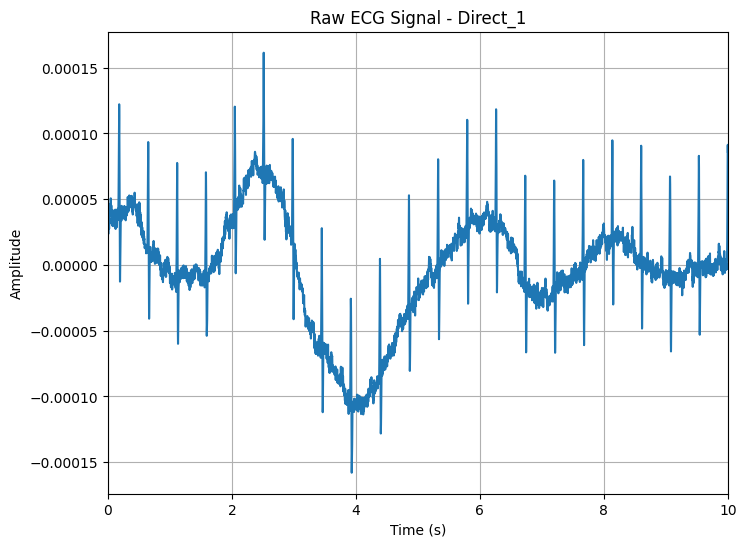

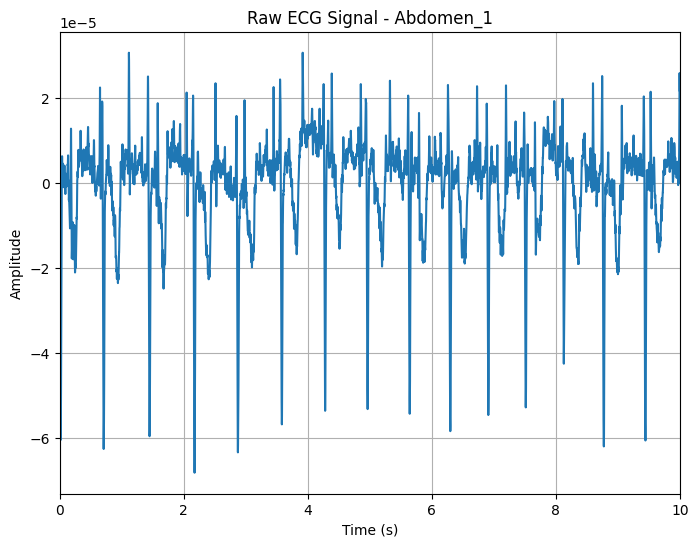

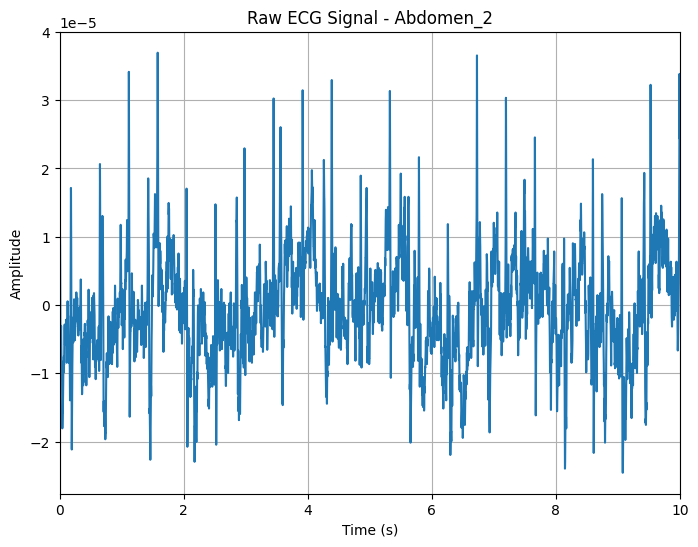

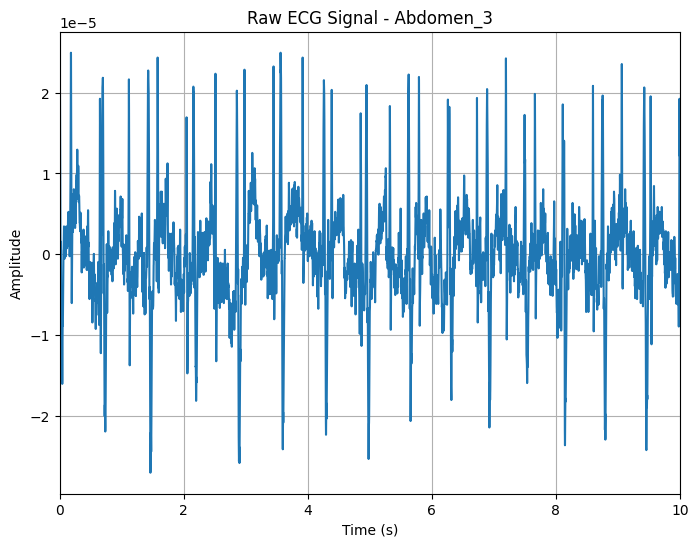

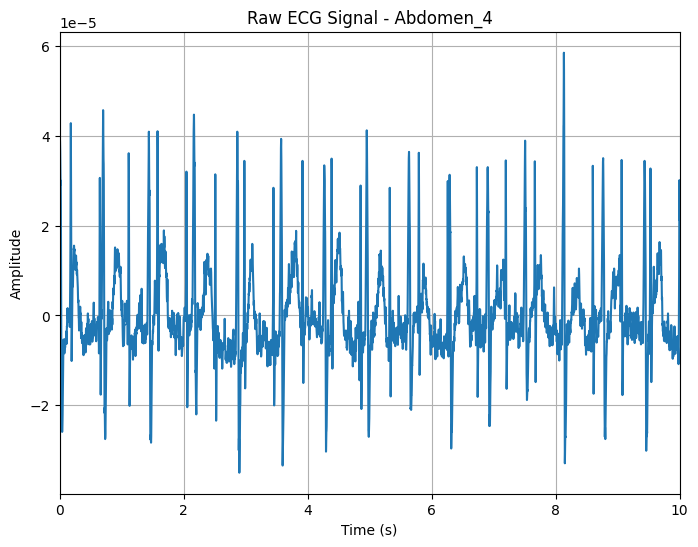

In [13]:
# Specifica il percorso dei file EDF
edf_file = 'abdominal/r01.edf'
raw = load_edf_file(edf_file)

channel = {0:"Direct_1", 1:"Abdomen_1", 2:"Abdomen_2", 3:"Abdomen_3", 4:"Abdomen_4"}

# Estrai i dati e le informazioni sui canali
data, times = raw[:, :]  # Dati e tempi
info = raw.info  # Informazioni sui canali
sampling_rate = 1000  # 1 kHz

# Definisci il periodo da visualizzare (in secondi)
period_seconds = 10
num_samples = period_seconds * sampling_rate

# Estrai i dati e i tempi per i primi 10 secondi
data_10s = data[:, :num_samples]
times_10s = times[:num_samples]

# Calcola e stampa BPM per ogni canale
for i in range(data_10s.shape[0]):
    bpm = calculate_bpm(data_10s[i], sampling_rate)
    print(f'{channel[i]} - Estimated BPM: {bpm:.2f}')

# Visualizzazione dei segnali grezzi per i primi 10 secondi su grafici separati
for i in range(data_10s.shape[0]):
    plt.figure(figsize=(8, 6))
    plt.plot(times_10s, data_10s[i])
    plt.title(f'Raw ECG Signal - {channel[i]}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.xlim([0, 10])
    plt.grid(True)
    plt.show()



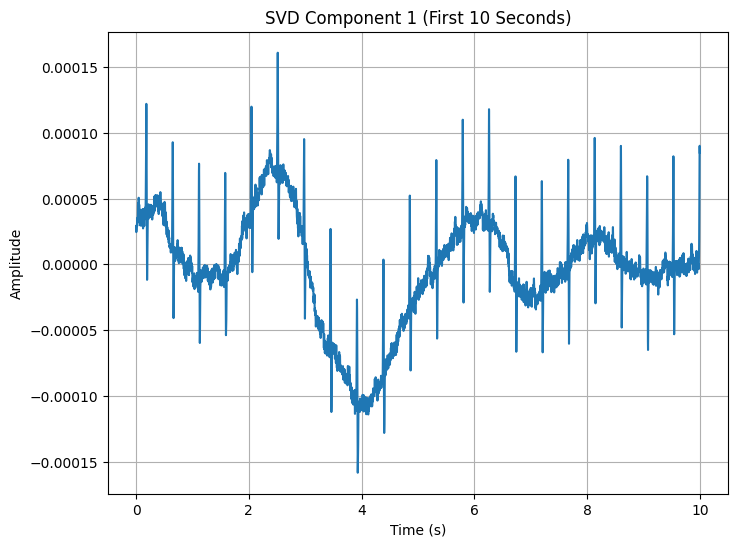

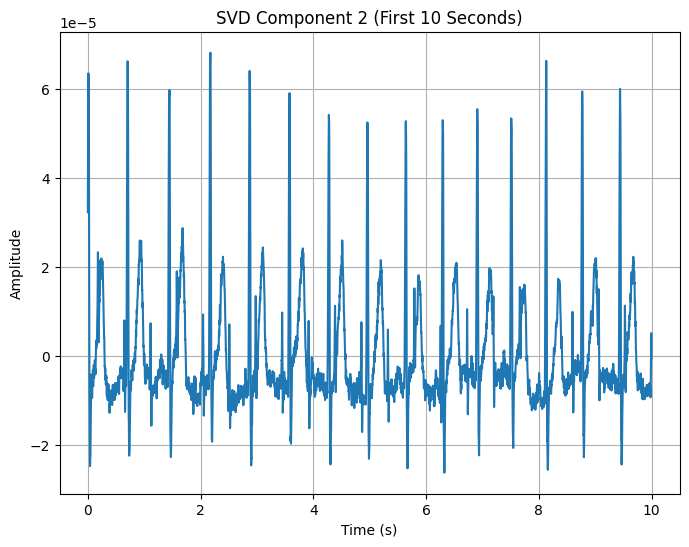

In [14]:
# Applicazione della SVD
n_components = 2  # Numero di componenti principali da mantenere
svd_data, svd = apply_svd(data_10s, n_components)
# Visualizzazione delle componenti principali per i primi 10 secondi su grafici separati
for i in range(n_components):
    plt.figure(figsize=(8, 6))
    plt.plot(times_10s, svd_data[:, i])
    plt.title(f'SVD Component {i+1} (First 10 Seconds)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

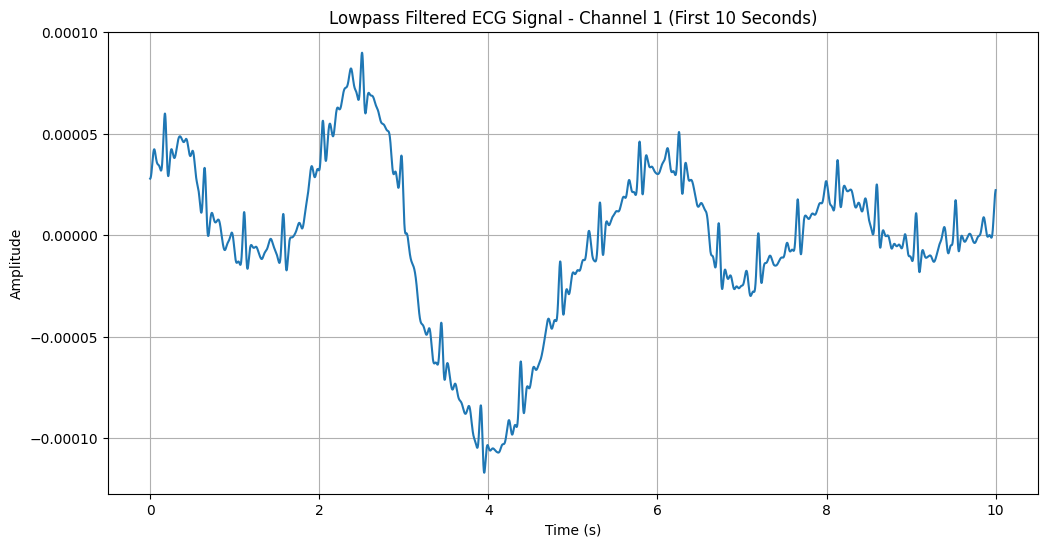

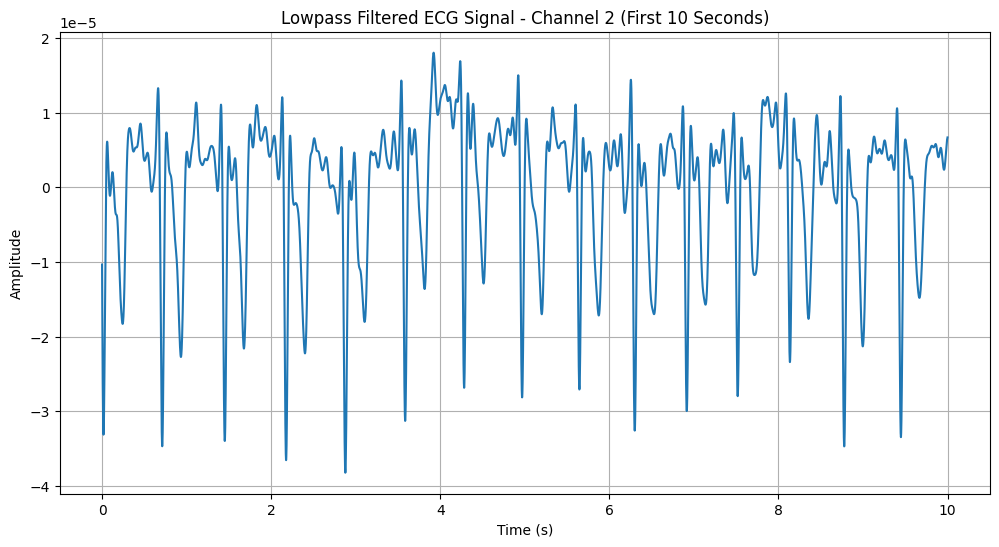

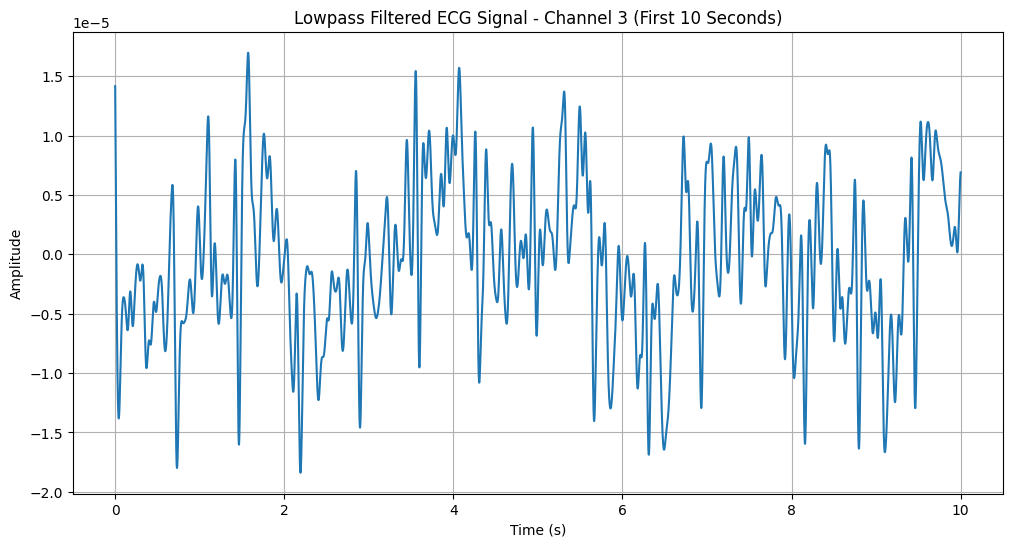

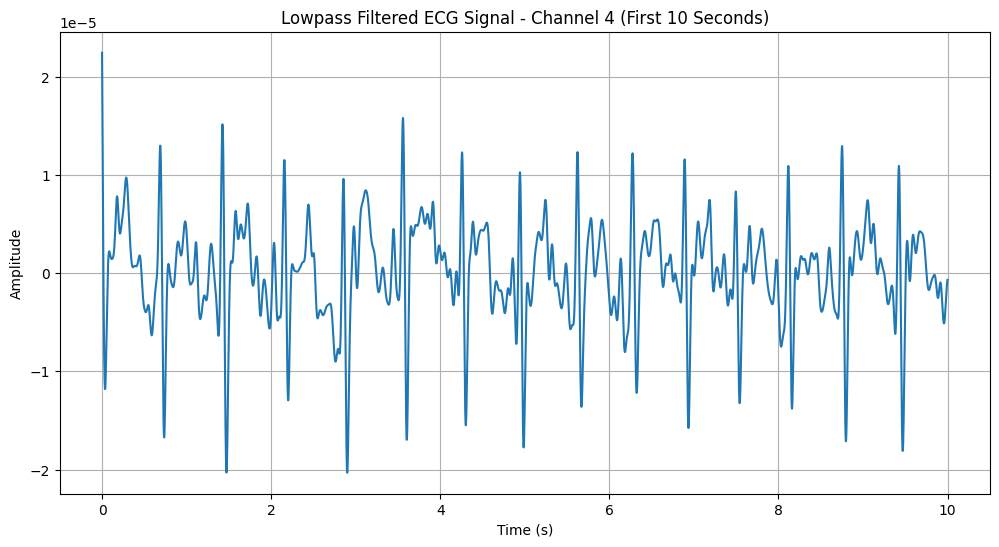

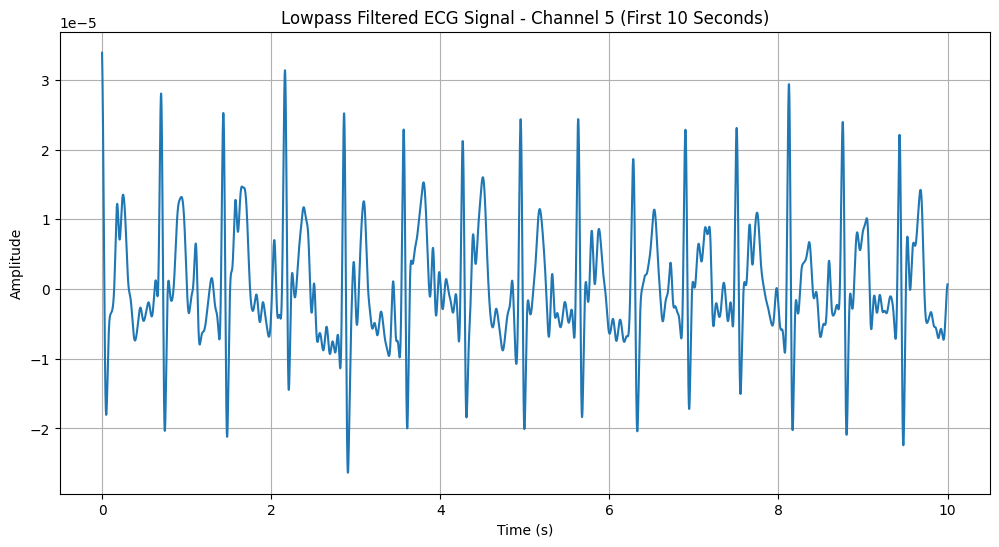

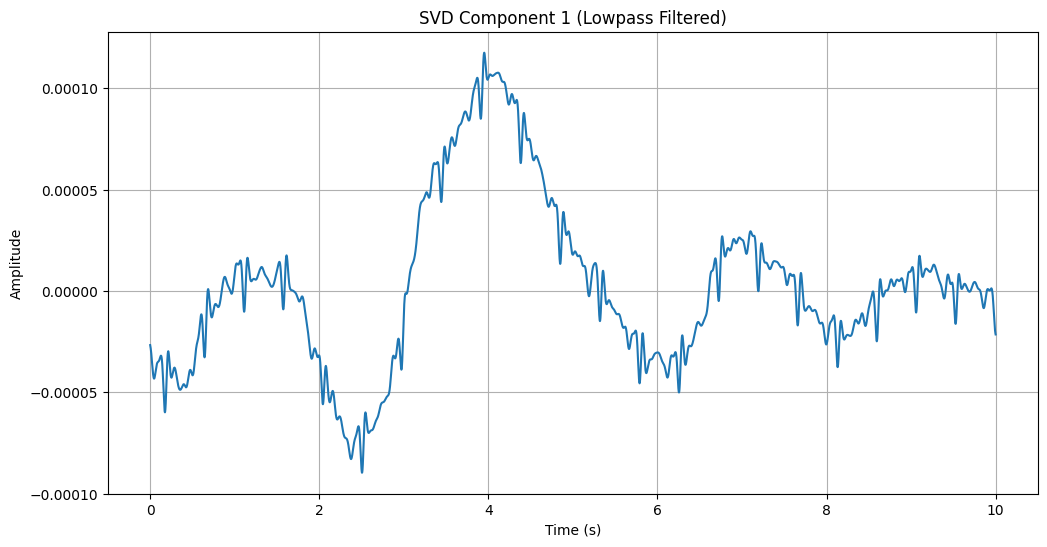

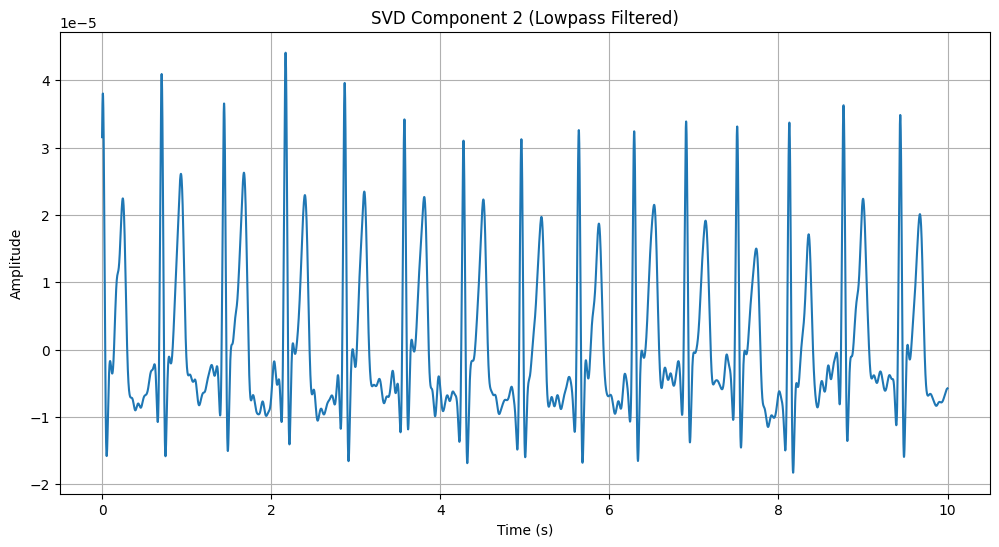

In [34]:
sampling_rate = 1000  # 1 kHz
num_samples = period_seconds * sampling_rate

# Applica il filtro passa-basso
cutoff_freq = 10  # Frequenza di taglio in Hz
filtered_data_lowpass = np.array([apply_lowpass_filter(ch, cutoff_freq, sampling_rate) for ch in data_10s])

# Applicazione della SVD
n_components = 2  # Numero di componenti principali da mantenere
svd_data_lowpass, svd = apply_svd(filtered_data_lowpass, n_components)

# Visualizzazione dei segnali filtrati per i primi 10 secondi su grafici separati
for i in range(filtered_data_lowpass.shape[0]):
    plt.figure(figsize=(12, 6))
    plt.plot(times_10s, filtered_data_lowpass[i])
    plt.title(f'Lowpass Filtered ECG Signal - Channel {i+1} (First 10 Seconds)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()



# Visualizzazione delle componenti principali per i primi 10 secondi su grafici separati
for i in range(n_components):
    plt.figure(figsize=(12, 6))
    plt.plot(times_10s, svd_data_lowpass[:, i])
    plt.title(f'SVD Component {i+1} (Lowpass Filtered)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()


In [35]:

print("BPM for SVD Components (Lowpass Filtered):")
for i in range(n_components):
    bpm = calculate_bpm(svd_data[:, i], sampling_rate)
    print(f'SVD Component {i+1} - Estimated BPM: {bpm:.2f}')
    
    bpm = calculate_bpm(svd_data_lowpass[:, i], sampling_rate)
    print(f'SVD lowpass Component {i+1} - Estimated BPM: {bpm:.2f}')

BPM for SVD Components (Lowpass Filtered):
SVD Component 1 - Estimated BPM: 132.00
SVD lowpass Component 1 - Estimated BPM: 120.00
SVD Component 2 - Estimated BPM: 96.00
SVD lowpass Component 2 - Estimated BPM: 96.00
